In [3]:
import yfinance as yf
import pandas as pd

# Task 1: Fetch Long Term data (2015-2024)
assets = ["AAPL", "MSFT", "GOOG", "AMZN", "TSLA"]
data_long = yf.download(assets, start="2015-01-01", end="2024-01-01", auto_adjust=False)

# Extract Adjusted Close and handle missing values
prices_long = data_long["Adj Close"].ffill().bfill()

# Display summary statistics
print("Long Term Data Summary:")
print(prices_long.describe())

# Check for any remaining NaN values
print("\nMissing values per asset:")
print(prices_long.isnull().sum())

# Task 1 Part 2: Fetch Medium Term data (2020-2024, includes COVID crash)
data_medium = yf.download(assets, start="2020-01-01", end="2024-01-01", auto_adjust=False)
prices_medium = data_medium["Adj Close"].ffill().bfill()

print("\nMedium Term Data Summary:")
print(prices_medium.describe())


[*********************100%***********************]  5 of 5 completed


Long Term Data Summary:
Ticker         AAPL         AMZN         GOOG         MSFT         TSLA
count   2264.000000  2264.000000  2264.000000  2264.000000  2264.000000
mean      81.394710    91.950540    73.063479   154.516907   102.886245
std       55.990879    48.654536    36.298158    99.658478   110.936400
min       20.604071    14.347500    24.377239    34.437160     9.578000
25%       32.814699    44.303625    41.515254    59.182488    16.670500
50%       51.220844    90.691998    59.376661   127.528790    23.160666
75%      139.017620   133.230000   104.133984   244.037376   214.290005
max      196.256546   186.570496   149.587067   377.077850   409.970001

Missing values per asset:
Ticker
AAPL    0
AMZN    0
GOOG    0
MSFT    0
TSLA    0
dtype: int64


[*********************100%***********************]  5 of 5 completed


Medium Term Data Summary:
Ticker         AAPL         AMZN         GOOG         MSFT         TSLA
count   1006.000000  1006.000000  1006.000000  1006.000000  1006.000000
mean     138.087082   137.216247   107.730848   254.761908   209.126371
std       33.389043    27.468805    25.245550    54.935815    85.797682
min       54.264332    81.820000    52.437714   128.929947    24.081333
25%      120.509670   114.309002    87.621826   213.318726   160.210003
50%      142.950012   140.585007   109.824055   251.500107   223.489998
75%      163.347748   161.190620   130.478901   294.432365   262.967491
max      196.256561   186.570496   149.587082   377.077850   409.970001


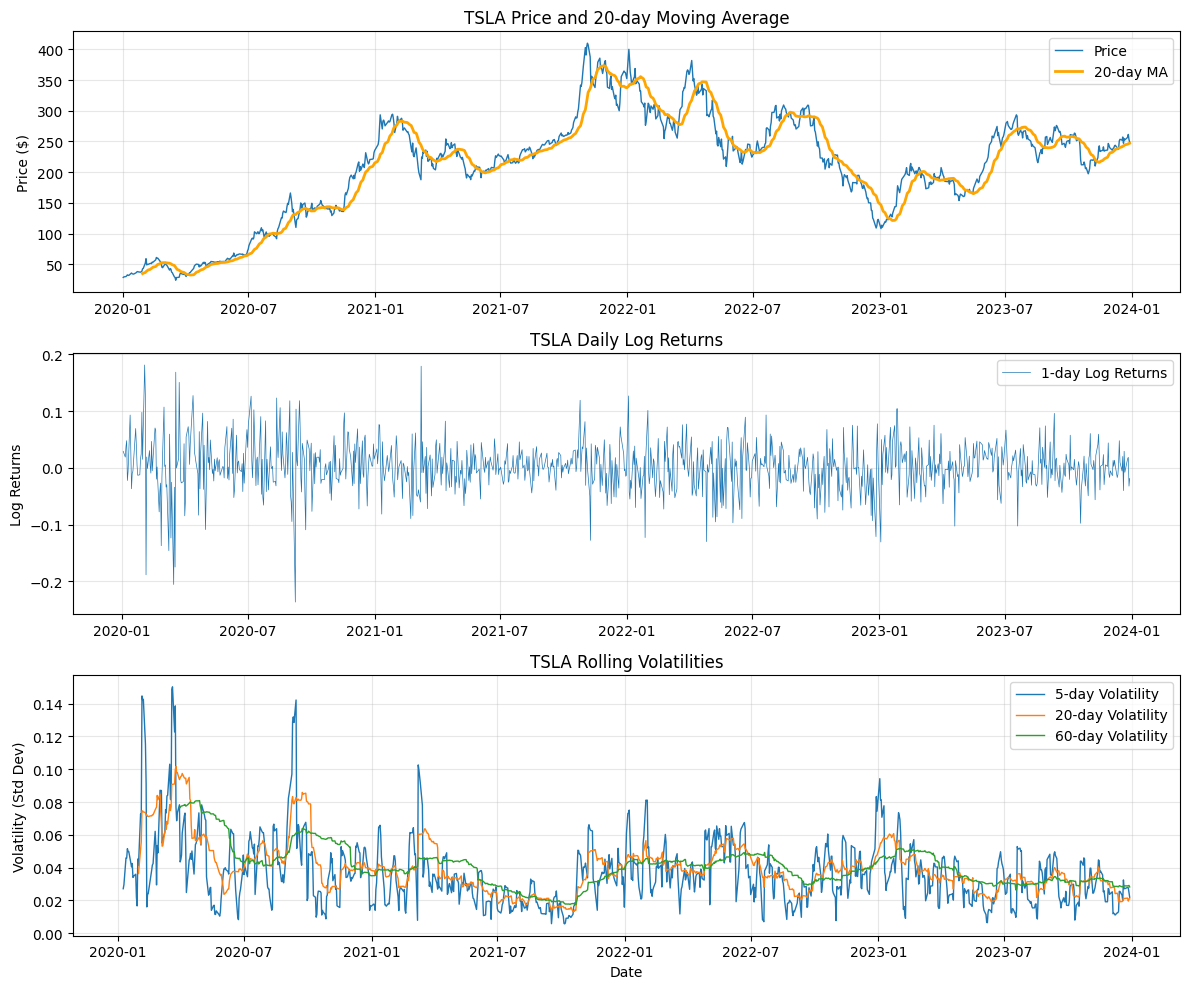

Analysis:
- High volatility periods coincide with price drops: [observe from plots]
- Volatility clusters: periods of high volatility tend to follow each other


In [4]:
# Task 2: Basic Trends
# Select one asset (e.g., TSLA) and use Medium Term data
import numpy as np
import matplotlib.pyplot as plt

asset = "TSLA"
prices = prices_medium[asset]

# Compute Returns and Log Returns
returns_1d = prices.pct_change(1)  # 1-day simple returns
returns_5d = prices.pct_change(5)  # 5-day simple returns
returns_20d = prices.pct_change(20)  # 20-day simple returns

log_returns_1d = np.log(prices / prices.shift(1))  # 1-day log returns
log_returns_5d = np.log(prices / prices.shift(5))  # 5-day log returns
log_returns_20d = np.log(prices / prices.shift(20))  # 20-day log returns

# Compute Volatility (rolling std dev of log returns)
vol_5d = log_returns_1d.rolling(5).std()
vol_20d = log_returns_1d.rolling(20).std()
vol_60d = log_returns_1d.rolling(60).std()

# Plotting
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

# Plot 1: Price and 20-day moving average
ma_20 = prices.rolling(20).mean()
axes[0].plot(prices.index, prices, label='Price', linewidth=1)
axes[0].plot(ma_20.index, ma_20, label='20-day MA', linewidth=2, color='orange')
axes[0].set_title(f'{asset} Price and 20-day Moving Average')
axes[0].set_ylabel('Price ($)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: 1-day log returns
axes[1].plot(log_returns_1d.index, log_returns_1d, label='1-day Log Returns', linewidth=0.5)
axes[1].set_title(f'{asset} Daily Log Returns')
axes[1].set_ylabel('Log Returns')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Rolling Volatilities
axes[2].plot(vol_5d.index, vol_5d, label='5-day Volatility', linewidth=1)
axes[2].plot(vol_20d.index, vol_20d, label='20-day Volatility', linewidth=1)
axes[2].plot(vol_60d.index, vol_60d, label='60-day Volatility', linewidth=1)
axes[2].set_title(f'{asset} Rolling Volatilities')
axes[2].set_ylabel('Volatility (Std Dev)')
axes[2].set_xlabel('Date')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analysis questions to answer:
print("Analysis:")
print(f"- High volatility periods coincide with price drops: [observe from plots]")
print(f"- Volatility clusters: periods of high volatility tend to follow each other")

[*********************100%***********************]  5 of 5 completed


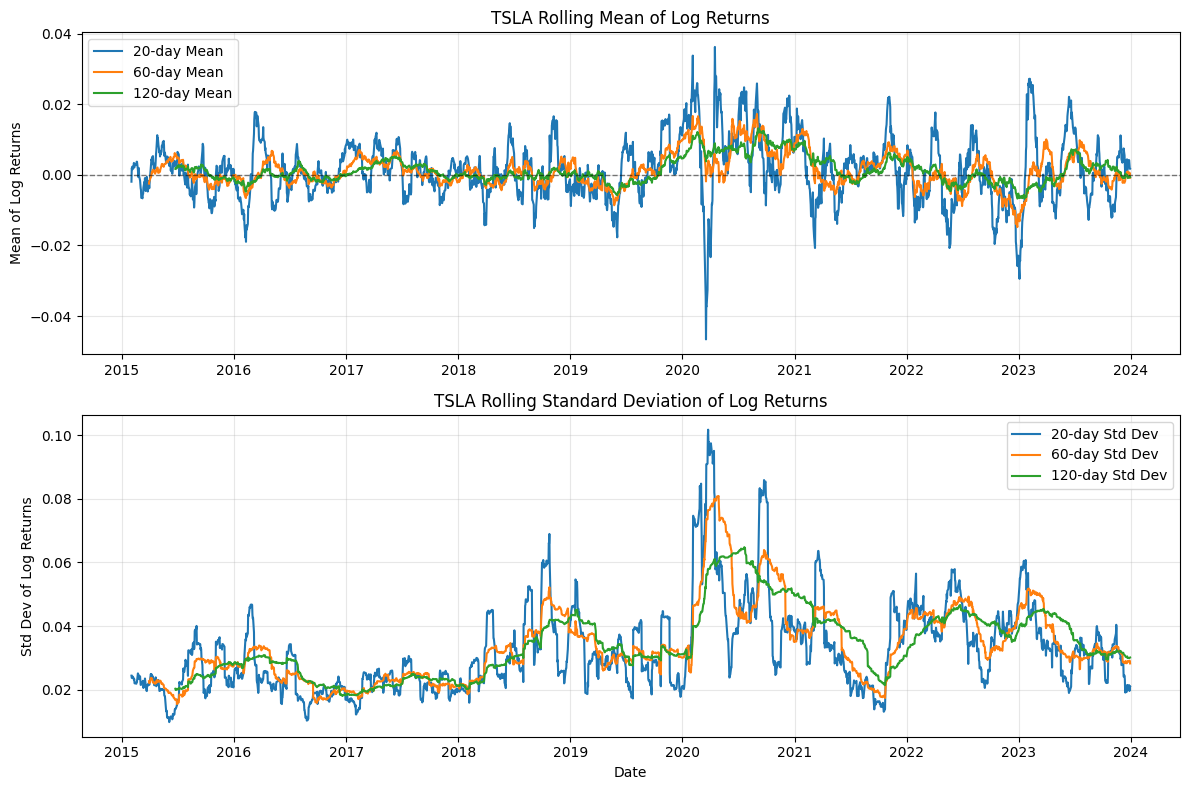

Visual Inspection:
- Does the mean stay constant? (Stationary mean)
  → If rolling means fluctuate around zero, mean is stationary
- Does the variance stay constant? (Stationary variance)
  → If rolling std devs are relatively stable, variance is stationary

Augmented Dickey-Fuller (ADF) Test Results
Test Statistic: -32.478200
P-value: 0.000000
Number of Lags Used: 1
Number of Observations: 2261

Critical Values:
  1%: -3.433
  5%: -2.863
  10%: -2.567

Interpretation:
✓ P-value (0.000000) < 0.05
✓ REJECT the Null Hypothesis (H0)
✓ Conclusion: The series IS STATIONARY (no unit root)
→ Log returns do NOT exhibit a trend and mean-revert over time

Note:
H0 (Null Hypothesis): Series has a unit root (non-stationary)
H1 (Alternative): Series does NOT have a unit root (stationary)


In [4]:
# Task 3: Stationarity
from statsmodels.tsa.stattools import adfuller

import yfinance as yf
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

# Task 1: Fetch Long Term data (2015-2024)
assets = ["AAPL", "MSFT", "GOOG", "AMZN", "TSLA"]
data_long = yf.download(assets, start="2015-01-01", end="2024-01-01", auto_adjust=False)

# Extract Adjusted Close and handle missing values
prices_long = data_long["Adj Close"].ffill().bfill()

# Select one asset using Long Term data
asset = "TSLA"
prices = prices_long[asset]

# Compute log returns
log_returns = np.log(prices / prices.shift(1)).dropna()

# Compute Rolling Mean and Rolling Standard Deviation with different window sizes
windows = [20, 60, 120]
rolling_means = {}
rolling_stds = {}

for window in windows:
    rolling_means[window] = log_returns.rolling(window).mean()
    rolling_stds[window] = log_returns.rolling(window).std()

# Plot rolling statistics
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Plot 1: Rolling Means
for window in windows:
    axes[0].plot(rolling_means[window].index, rolling_means[window], label=f'{window}-day Mean', linewidth=1.5)
axes[0].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[0].set_title(f'{asset} Rolling Mean of Log Returns')
axes[0].set_ylabel('Mean of Log Returns')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Rolling Standard Deviations
for window in windows:
    axes[1].plot(rolling_stds[window].index, rolling_stds[window], label=f'{window}-day Std Dev', linewidth=1.5)
axes[1].set_title(f'{asset} Rolling Standard Deviation of Log Returns')
axes[1].set_ylabel('Std Dev of Log Returns')
axes[1].set_xlabel('Date')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Visual Inspection and Analysis
print("Visual Inspection:")
print("- Does the mean stay constant? (Stationary mean)")
print("  → If rolling means fluctuate around zero, mean is stationary")
print("- Does the variance stay constant? (Stationary variance)")
print("  → If rolling std devs are relatively stable, variance is stationary")
print()

# Run Augmented Dickey-Fuller (ADF) Test
print("=" * 60)
print("Augmented Dickey-Fuller (ADF) Test Results")
print("=" * 60)

adf_result = adfuller(log_returns, autolag='AIC')

print(f"Test Statistic: {adf_result[0]:.6f}")
print(f"P-value: {adf_result[1]:.6f}")
print(f"Number of Lags Used: {adf_result[2]}")
print(f"Number of Observations: {adf_result[3]}")
print("\nCritical Values:")
for key, value in adf_result[4].items():
    print(f"  {key}: {value:.3f}")

print("\n" + "=" * 60)
print("Interpretation:")
print("=" * 60)

if adf_result[1] < 0.05:
    print(f"✓ P-value ({adf_result[1]:.6f}) < 0.05")
    print("✓ REJECT the Null Hypothesis (H0)")
    print("✓ Conclusion: The series IS STATIONARY (no unit root)")
    print("→ Log returns do NOT exhibit a trend and mean-revert over time")
else:
    print(f"✗ P-value ({adf_result[1]:.6f}) >= 0.05")
    print("✗ FAIL TO REJECT the Null Hypothesis (H0)")
    print("✗ Conclusion: The series is NON-STATIONARY (has unit root)")
    print("→ Log returns may have trends or drift")

print("\nNote:")
print("H0 (Null Hypothesis): Series has a unit root (non-stationary)")
print("H1 (Alternative): Series does NOT have a unit root (stationary)")

[*********************100%***********************]  5 of 5 completed


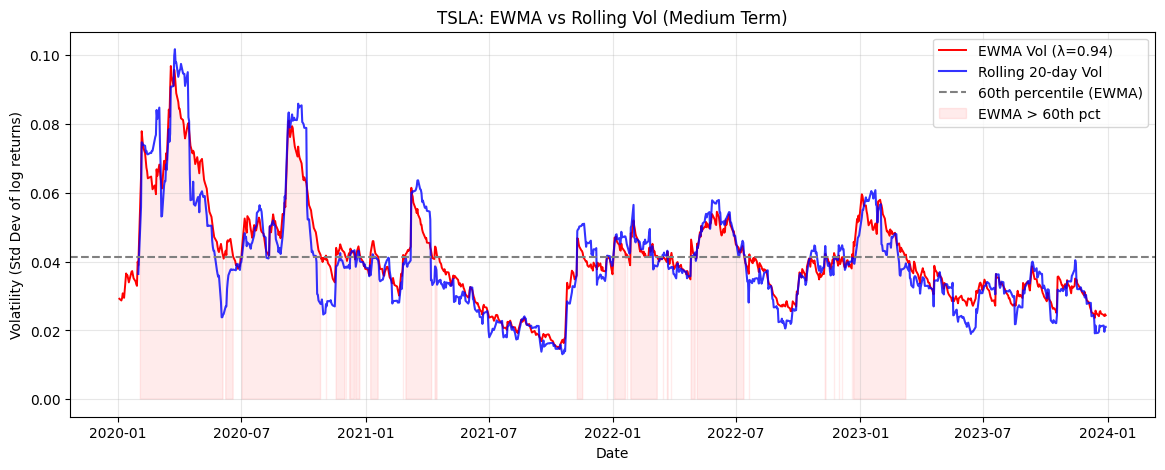

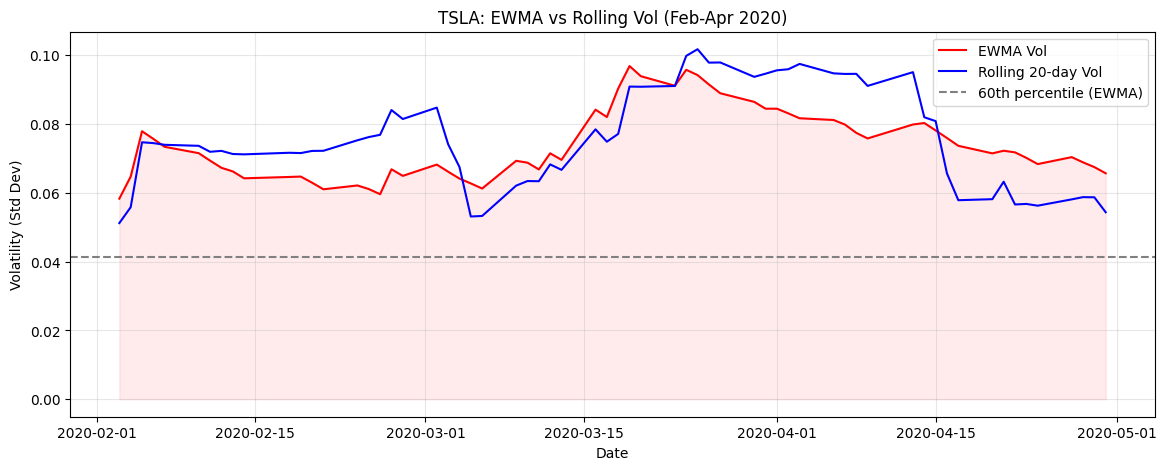

Variance of z_t using EWMA σ̂_t: 0.9135


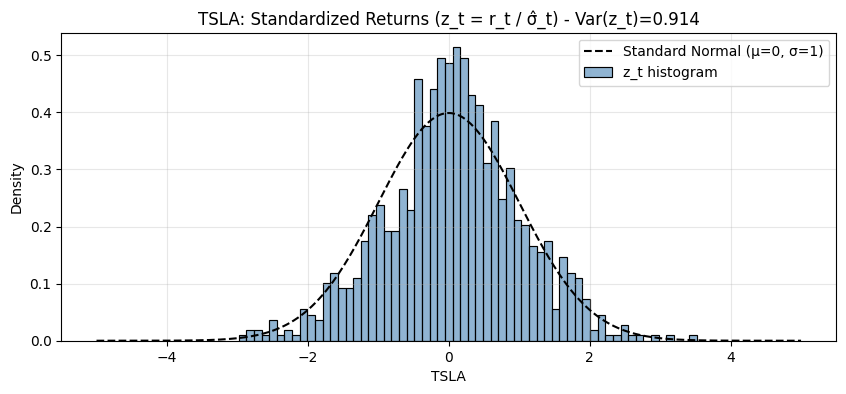

Short interpretation tips:
- Which is smoother? EWMA is typically smoother for the same 'memory' if using lambda close to 1.
- Which reacts faster? Rolling 20-day reacts to new variance quickly but so can EWMA depending on alpha. With λ=0.94 (α=0.06), EWMA responds moderately fast to events but is smoother overall.
- High EWMA / rolling vol spikes during Feb-Mar 2020 confirm a turbulent regime (COVID crash).
- Var(z_t) should be near 1 if EWMA accurately models conditional volatility; large deviations -> model misses heavy tails or mean reversion.


In [5]:
# Task 4: Volatility Regimes (Rolling 20-day vs EWMA)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns  # optional, handy for histograms

# Fallback: ensure prices_medium exists. If not, fetch it.
try:
    prices_medium
except NameError:
    import yfinance as yf
    assets = ["AAPL", "MSFT", "GOOG", "AMZN", "TSLA"]
    data_medium = yf.download(assets, start="2020-01-01", end="2024-01-01", auto_adjust=False)
    prices_medium = data_medium["Adj Close"].ffill().bfill()

# Set asset if not defined
try:
    asset
except NameError:
    asset = "TSLA"

# Select the series and compute log returns (drop NaNs)
prices = prices_medium[asset].dropna()
log_returns = np.log(prices / prices.shift(1)).dropna()

# 1) Rolling 20-day volatility (SMA of std dev)
rolling_window = 20
vol_rolling20 = log_returns.rolling(rolling_window).std()

# 2) EWMA volatility (RiskMetrics) with lambda = 0.94 -> alpha = 0.06
lam = 0.94
alpha = 1 - lam
ewma_var = (log_returns ** 2).ewm(alpha=alpha, adjust=False).mean()  # this returns variance (EWM of squared returns)
ewma_vol = np.sqrt(ewma_var)  # EWMA std dev

# 60th percentile threshold for EWMA (computed over whole medium series)
thres_60 = ewma_vol.quantile(0.60)

# Subset to COVID crash window for close inspection (Feb-Apr 2020)
covid_start, covid_end = "2020-02-01", "2020-04-30"
idx_covid = (log_returns.index >= covid_start) & (log_returns.index <= covid_end)

# Plot: Full medium period with EWMA threshold shading
plt.figure(figsize=(14, 5))
plt.plot(ewma_vol.index, ewma_vol, label=f'EWMA Vol (λ={lam})', color='red', linewidth=1.4)
plt.plot(vol_rolling20.index, vol_rolling20, label=f'Rolling {rolling_window}-day Vol', color='blue', alpha=0.8)
plt.axhline(thres_60, color='gray', linestyle='--', label='60th percentile (EWMA)')
# shade regions where ewma_vol > threshold
mask_exceed = ewma_vol > thres_60
plt.fill_between(ewma_vol.index, 0, ewma_vol, where=mask_exceed, color='red', alpha=0.08, label='EWMA > 60th pct')
plt.title(f'{asset}: EWMA vs Rolling Vol (Medium Term)')
plt.xlabel('Date')
plt.ylabel('Volatility (Std Dev of log returns)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot: Focus on COVID window
plt.figure(figsize=(14, 5))
plt.plot(ewma_vol.index[idx_covid], ewma_vol[idx_covid], label='EWMA Vol', color='red')
plt.plot(vol_rolling20.index[idx_covid], vol_rolling20[idx_covid], label=f'Rolling {rolling_window}-day Vol', color='blue')
plt.axhline(thres_60, color='gray', linestyle='--', label='60th percentile (EWMA)')
plt.fill_between(ewma_vol.index[idx_covid], 0, ewma_vol[idx_covid], where=ewma_vol[idx_covid] > thres_60, color='red', alpha=0.08)
plt.title(f'{asset}: EWMA vs Rolling Vol (Feb-Apr 2020)')
plt.xlabel('Date')
plt.ylabel('Volatility (Std Dev)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Compute standardized returns (z_t = r_t / sigma_hat_t). We'll use EWMA vol for sigma_hat.
# Align series: EWMA vol and returns must share the same index
sigma_hat = ewma_vol.reindex(log_returns.index).ffill()  # forward fill short NaNs if needed
z = log_returns / sigma_hat
z = z.dropna()

# Check variance of z
variance_z = z.var()
print(f'Variance of z_t using EWMA σ̂_t: {variance_z:.4f}')

# Show histogram of standardized returns (compare with standard normal)
plt.figure(figsize=(10, 4))
sns.histplot(z, bins=60, kde=False, stat='density', color='steelblue', alpha=0.6, label='z_t histogram')
# Overlay normal distribution with mean 0 and std 1
x = np.linspace(-5, 5, 400)
plt.plot(x, 1/(np.sqrt(2*np.pi)) * np.exp(-x**2/2), color='k', linestyle='--', label='Standard Normal (μ=0, σ=1)')
plt.title(f'{asset}: Standardized Returns (z_t = r_t / σ̂_t) - Var(z_t)={variance_z:.3f}')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Optional: print a short summary for interpretation
print("Short interpretation tips:")
print("- Which is smoother? EWMA is typically smoother for the same 'memory' if using lambda close to 1.")
print("- Which reacts faster? Rolling 20-day reacts to new variance quickly but so can EWMA depending on alpha. With λ=0.94 (α=0.06), EWMA responds moderately fast to events but is smoother overall.")
print("- High EWMA / rolling vol spikes during Feb-Mar 2020 confirm a turbulent regime (COVID crash).")
print("- Var(z_t) should be near 1 if EWMA accurately models conditional volatility; large deviations -> model misses heavy tails or mean reversion.")

C:\Users\parth\AppData\Local\Temp\ipykernel_51244\3608288895.py:21: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  prices_monthly = prices.resample('M').last()


Asset: TSLA

Horizon | n | mean | std | skew | kurtosis | excess_kurtosis
Daily  | 2263 | 0.00125 | 0.03551 | -0.1633 | 7.517 | 4.517
Weekly |  469 | 0.00604 | 0.07884 | 0.0782 | 4.332 | 1.332
Monthly |  107 | 0.02717 | 0.16726 | 0.3997 | 3.691 | 0.691


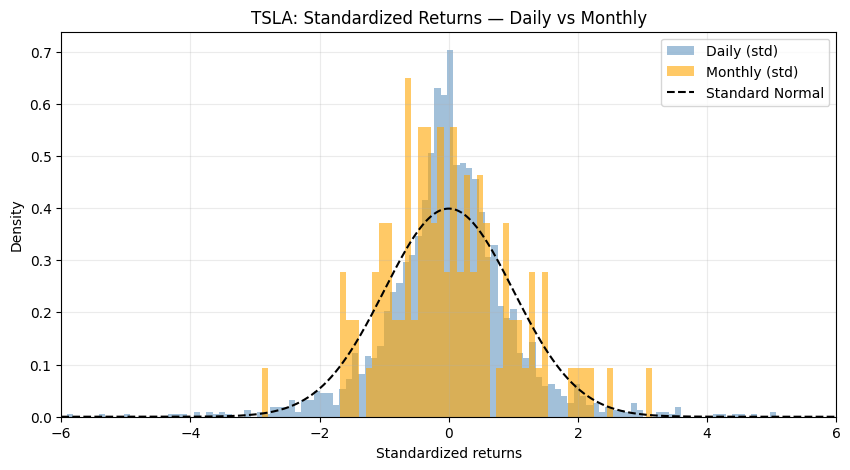

In [6]:
# Task 5: Time Horizons & the "Normal" Illusion
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure long-term prices exist (fetch if needed)
try:
    prices_long
except NameError:
    import yfinance as yf
    assets = ["AAPL","MSFT","GOOG","AMZN","TSLA","NVDA"]
    data_long = yf.download(assets, start="2015-01-01", end="2024-01-01", auto_adjust=False)
    prices_long = data_long["Adj Close"].ffill().bfill()

# Choose asset: prefer NVDA for Task 5, fallback to TSLA
asset = "NVDA" if "NVDA" in prices_long.columns else "TSLA"
prices = prices_long[asset].dropna()

# Resample to weekly / monthly closes
prices_weekly = prices.resample('W').last()
prices_monthly = prices.resample('M').last()

# Log returns
lr_daily = np.log(prices / prices.shift(1)).dropna()
lr_weekly = np.log(prices_weekly / prices_weekly.shift(1)).dropna()
lr_monthly = np.log(prices_monthly / prices_monthly.shift(1)).dropna()

# Compute statistics (skew and kurtosis). Use scipy if available for standard kurtosis (not excess)
try:
    from scipy.stats import kurtosis as sp_kurtosis
    use_scipy = True
except Exception:
    use_scipy = False

def summary(s):
    mean = s.mean()
    sd = s.std()
    skew = s.skew()
    if use_scipy:
        kurt = float(sp_kurtosis(s, fisher=False, bias=False))      # standard kurtosis (~3 for normal)
        excess = kurt - 3
    else:
        excess = s.kurtosis()                                       # pandas gives excess kurtosis
        kurt = excess + 3
    return {"n": s.size, "mean": mean, "std": sd, "skew": skew, "kurtosis": kurt, "excess_kurtosis": excess}

summaries = { "Daily": summary(lr_daily), "Weekly": summary(lr_weekly), "Monthly": summary(lr_monthly) }

# Print table-like summary
print(f"Asset: {asset}\n")
print("Horizon | n | mean | std | skew | kurtosis | excess_kurtosis")
for k, v in summaries.items():
    print(f"{k:6} | {v['n']:4d} | {v['mean']:.5f} | {v['std']:.5f} | {v['skew']:.4f} | {v['kurtosis']:.3f} | {v['excess_kurtosis']:.3f}")

# Plot standardized histograms: Daily vs Monthly (standardize to mean 0, std 1)
z_daily = (lr_daily - lr_daily.mean()) / lr_daily.std()
z_monthly = (lr_monthly - lr_monthly.mean()) / lr_monthly.std()

plt.figure(figsize=(10,5))
plt.hist(z_daily, bins=120, density=True, alpha=0.5, label='Daily (std)', color='steelblue')
plt.hist(z_monthly, bins=60, density=True, alpha=0.6, label='Monthly (std)', color='orange')
# overlay standard normal
x = np.linspace(-6, 6, 400)
plt.plot(x, 1/np.sqrt(2*np.pi)*np.exp(-x**2/2), 'k--', label='Standard Normal')
plt.xlim(-6, 6)
plt.xlabel('Standardized returns')
plt.ylabel('Density')
plt.title(f'{asset}: Standardized Returns — Daily vs Monthly')
plt.legend()
plt.grid(alpha=0.25)
plt.show()

[*********************100%***********************]  1 of 1 completed
C:\Users\parth\AppData\Local\Temp\ipykernel_51244\1371184852.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  purchase_price = float(adj.loc[purchase_idx])
C:\Users\parth\AppData\Local\Temp\ipykernel_51244\1371184852.py:39: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_price = float(adj.loc[last_idx])
C:\Users\parth\AppData\Local\Temp\ipykernel_51244\1371184852.py:80: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  initial_val = float(portfolio_series.iloc[0])
C:\Users\parth\AppData\Local\Temp\ipykernel_51244\1371184852.py:89: FutureWarning: Calling float on a single element Series is deprecated and will raise a Type

----- Investment Summary -----
NVDA purchase executed on: 2007-09-05 @ Adj Close = $0.80
Shares bought (fractional allowed): 1,250.336279
Latest price on 2025-12-12: $175.02
Portfolio value today: $218,833.86
Return on investment (ROI): 21783.39%
Compound Annual Growth Rate (CAGR): 34.30%

----- RTX 4090 Purchasing Power -----
RTX 4090 unit price (assumed): $1,600.00
Fractional RTX 4090s affordable: 136.7712
Whole RTX 4090s affordable: 136 (with $1,233.86 leftover)
------------------------------


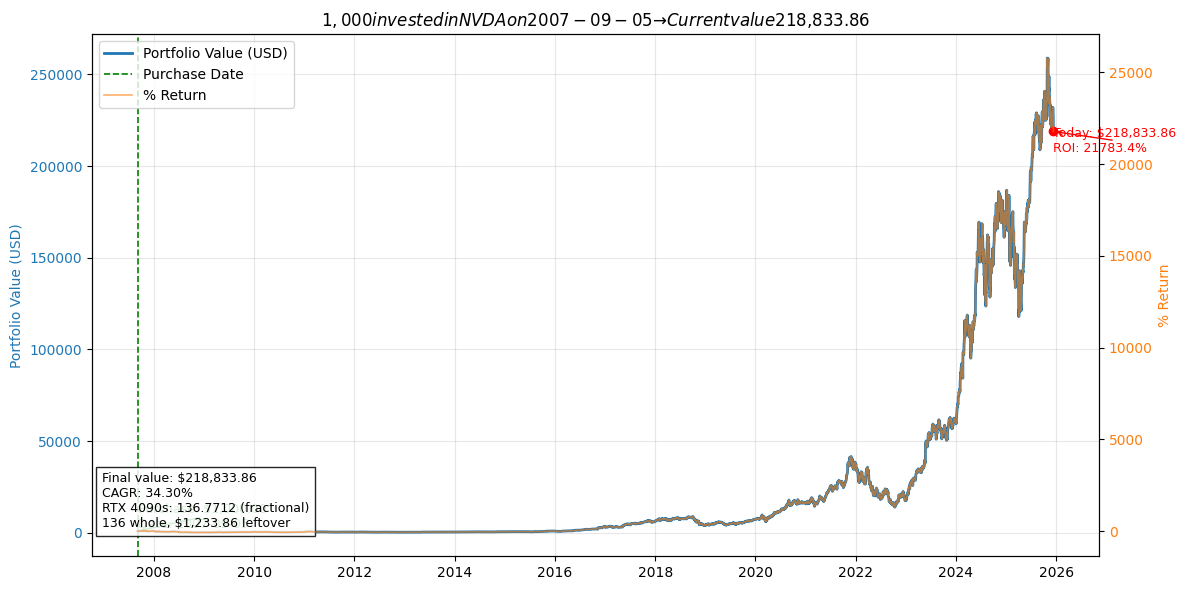

In [9]:
# ---- Combined Task 6 + Portfolio Plot (fixed) ----
# If $1,000 was invested in NVDA on DOB (2007-09-05), how much is it worth now?
# Also plot time vs portfolio value and show RTX 4090 purchasing power.
import math
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# Parameters
dob = "2007-09-05"
invest_amount = 1000.0
rtx_price = 1600.0  # adjust if needed
ticker = "NVDA"     # ticker to invest

# Download NVDA data (using Adjusted Close)
end_date = pd.Timestamp.today().strftime("%Y-%m-%d")
data = yf.download(ticker, start=dob, end=end_date, auto_adjust=False)

if data.empty or "Adj Close" not in data.columns:
    raise RuntimeError("Failed to fetch NVDA price history. Check internet connection or ticker availability.")

adj = data["Adj Close"].dropna()

# Find first available trading day on/after DOB
purchase_idx = adj[adj.index >= pd.to_datetime(dob)].first_valid_index()
if purchase_idx is None:
    raise RuntimeError(f"No {ticker} price available on or after {dob} (ticker may not exist then).")

purchase_date = purchase_idx.date()
purchase_price = float(adj.loc[purchase_idx])

# Compute shares purchased and current portfolio value
shares = invest_amount / purchase_price  # fractional shares allowed
last_idx = adj.last_valid_index()
current_date = last_idx.date()
current_price = float(adj.loc[last_idx])
final_value = shares * current_price

# Metrics
roi = (final_value / invest_amount) - 1.0
days = (current_date - purchase_date).days
years = days / 365.25 if days > 0 else 1.0
cagr = (final_value / invest_amount) ** (1 / years) - 1 if years > 0 else float('nan')

fractional_4090 = final_value / rtx_price
whole_4090 = math.floor(fractional_4090)

# Print summary
print("----- Investment Summary -----")
print(f"{ticker} purchase executed on: {purchase_date} @ Adj Close = ${purchase_price:,.2f}")
print(f"Shares bought (fractional allowed): {shares:,.6f}")
print(f"Latest price on {current_date}: ${current_price:,.2f}")
print(f"Portfolio value today: ${final_value:,.2f}")
print(f"Return on investment (ROI): {roi*100:.2f}%")
print(f"Compound Annual Growth Rate (CAGR): {cagr*100:.2f}%")
print()
print("----- RTX 4090 Purchasing Power -----")
print(f"RTX 4090 unit price (assumed): ${rtx_price:,.2f}")
print(f"Fractional RTX 4090s affordable: {fractional_4090:,.4f}")
print(f"Whole RTX 4090s affordable: {whole_4090} (with ${final_value - whole_4090*rtx_price:,.2f} leftover)")
print("------------------------------")

# ---- Build portfolio time series and plot ----
portfolio_series = shares * adj.loc[purchase_idx:]  # value from purchase date onwards
pct_return_ts = (portfolio_series / invest_amount - 1.0) * 100.0

plt.figure(figsize=(12, 6))
ax = plt.gca()

# Portfolio value (left axis)
ax.plot(portfolio_series.index, portfolio_series.values, label='Portfolio Value (USD)', color='tab:blue', linewidth=2)
ax.set_ylabel("Portfolio Value (USD)", color='tab:blue')
ax.tick_params(axis='y', labelcolor='tab:blue')
ax.set_title(f"${invest_amount:,.0f} invested in {ticker} on {purchase_date} → Current value ${final_value:,.2f}")

# Annotate purchase date and initial value (ensure scalar floats)
initial_val = float(portfolio_series.iloc[0])
ax.axvline(purchase_idx, color='green', linestyle='--', linewidth=1.2, label='Purchase Date')
ax.annotate(f"Purchase: ${initial_val:,.2f}\nDate: {purchase_date}",
            xy=(purchase_idx, initial_val),
            xytext=(purchase_idx, initial_val * 1.02),
            arrowprops=dict(arrowstyle='->', color='green'),
            color='green', fontsize=9, va='bottom')

# Annotate final value (ensure scalar float)
final_val_scalar = float(portfolio_series.iloc[-1])
ax.scatter(portfolio_series.index[-1], final_val_scalar, color='red', zorder=5)
ax.annotate(f"Today: ${final_val_scalar:,.2f}\nROI: {roi*100:.1f}%",
            xy=(portfolio_series.index[-1], final_val_scalar),
            xytext=(portfolio_series.index[-1], final_val_scalar * 0.95),
            arrowprops=dict(arrowstyle='->', color='red'), color='red', fontsize=9, ha='left')

# x-axis formatting
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))
ax.grid(alpha=0.3)

# Secondary axis: percent return
ax2 = ax.twinx()
ax2.plot(pct_return_ts.index, pct_return_ts.values, label='% Return', color='tab:orange', alpha=0.6, linewidth=1.2)
ax2.set_ylabel('% Return', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Combine legends
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='upper left')

# Small box to show RTX 4090 counts and CAGR
textstr = (
    f"Final value: ${final_value:,.2f}\n"
    f"CAGR: {cagr*100:.2f}%\n"
    f"RTX 4090s: {fractional_4090:,.4f} (fractional)\n"
    f"{whole_4090} whole, ${final_value - whole_4090*rtx_price:,.2f} leftover"
)
ax.text(0.01, 0.05, textstr, transform=ax.transAxes, fontsize=9,
        bbox=dict(facecolor='white', alpha=0.85), ha='left', va='bottom')

plt.tight_layout()
plt.show()